In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import models, layers
import os
from keras.models import load_model

In [2]:
import tensorflow_datasets as tfds
(ds_train, ds_test),ds_info=tfds.load('cats_vs_dogs',
                                      split=['train[:10%]', 'train[98%:]'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True)

In [3]:
image_size = (256, 256)

In [4]:
#ds_train=tf.keras.utils.image_dataset_from_directory("ProjectDir_Pet/train",batch_size=20)

In [5]:
#ds_test=tf.keras.utils.image_dataset_from_directory("ProjectDir_Pet/test",batch_size=20)

In [6]:
def normalize_img(image, label):
    # Resize the image to the desired dimensions
    image = tf.image.resize(image, image_size)
    # Normalize images: uint8 -> float32
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(40)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [7]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [9]:
model = models.Sequential()
model.add(layers.Input(shape=(256, 256, 3)))
model.add(data_augmentation)
model.add( layers.Conv2D( 32, (5, 5 ), activation = 'tanh',kernel_initializer='glorot_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (5, 5 ),kernel_initializer='glorot_uniform', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(32,kernel_initializer='he_normal',activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1,kernel_initializer='he_normal', activation = 'sigmoid'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 252, 252, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      51264     
                                                                 
 batch_normalization_1 (Bat  (None, 122, 122, 64)     

In [11]:
history = model.compile(
    optimizer = tf.keras.optimizers.Adam(0.01),
    #loss='binary_crossentropy', 
    #metrics=['accuracy']
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [12]:
history = model.fit(
    ds_train,  
    epochs=50,
    validation_data=ds_test,
) 
print('Number of total epochs ran:')
len(history.history['val_binary_accuracy']) 

Epoch 1/50
19/19 [==============================] - 250s 13s/step - loss: 0.8349 - binary_accuracy: 0.5284 - val_loss: 1.0589 - val_binary_accuracy: 0.4903
Epoch 2/50
19/19 [==============================] - 245s 12s/step - loss: 0.7188 - binary_accuracy: 0.5353 - val_loss: 1.0581 - val_binary_accuracy: 0.4817
Epoch 3/50
19/19 [==============================] - 253s 13s/step - loss: 0.6956 - binary_accuracy: 0.5331 - val_loss: 0.7093 - val_binary_accuracy: 0.5097
Epoch 4/50
19/19 [==============================] - 248s 13s/step - loss: 0.6762 - binary_accuracy: 0.5731 - val_loss: 0.6974 - val_binary_accuracy: 0.5226
Epoch 5/50
19/19 [==============================] - 245s 13s/step - loss: 0.6685 - binary_accuracy: 0.5860 - val_loss: 0.7032 - val_binary_accuracy: 0.5075
Epoch 6/50
19/19 [==============================] - 240s 13s/step - loss: 0.6713 - binary_accuracy: 0.5709 - val_loss: 0.7270 - val_binary_accuracy: 0.5075
Epoch 7/50
19/19 [==============================] - 242s 13s/ste

50

In [13]:
#model.load_weights('best_model.h5')

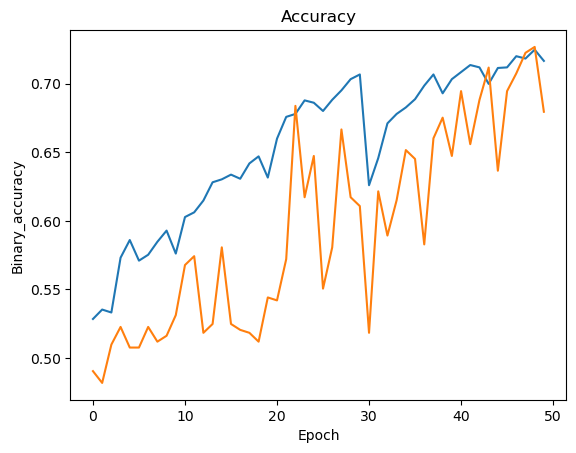

In [14]:
import matplotlib.pyplot as plt
epochs= range(1, 50+1) 
plt.plot(history.history['binary_accuracy']) 
plt.plot(history.history['val_binary_accuracy']) 
plt.title('Accuracy') 
plt.ylabel('Binary_accuracy') 
plt.xlabel('Epoch') 
plt.show()

In [15]:
import matplotlib.pyplot as plt

class_name=['cat', 'dog']

3/3 [==============================] - 2s 458ms/step


C:\Users\selpa\AppData\Local\Temp\ipykernel_24768\2471148957.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,4, i+1)


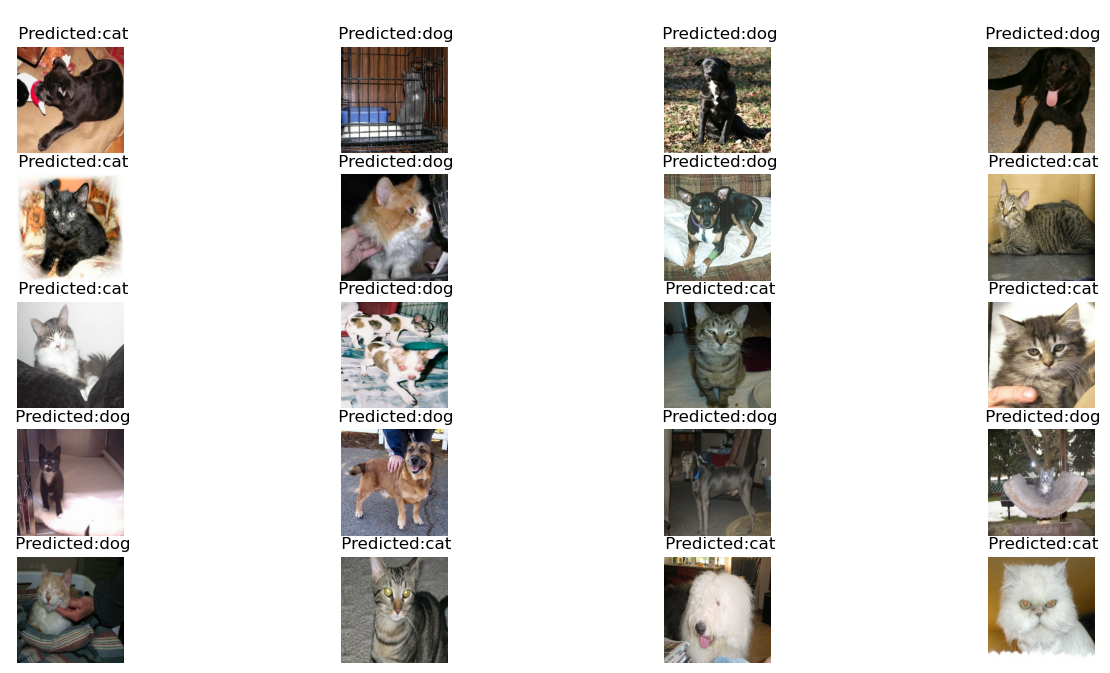

In [16]:
for images, labels in ds_test.take(20):
    predictions = model.predict(images)
    
def image_print(i, prediction_arr, img):
    prediction_label = int(prediction_arr[i] >0.5) #1 if greater than 0.5, 0 if less than 0.5 , since we used sigmoid
    plt.imshow(img[i])
    plt.title(f'\n Predicted:{class_name[prediction_label]}')
    plt.axis('off')
    
fig, axes = plt.subplots(4,5, figsize=(16,8))
for i in range(20):#since there are 20 images
    plt.subplot(5,4, i+1)
    image_print(i, predictions, images)
plt.show()

In [17]:
history = model.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    #loss='binary_crossentropy', 
    #metrics=['accuracy']
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [18]:
history = model.fit(
    ds_train,  
    epochs=20,
    validation_data=ds_test,
) 
print('Number of total epochs ran:')
len(history.history['val_binary_accuracy']) 

Epoch 1/20
19/19 [==============================] - 236s 12s/step - loss: 0.5265 - binary_accuracy: 0.7330 - val_loss: 0.5507 - val_binary_accuracy: 0.7032
Epoch 2/20
19/19 [==============================] - 226s 12s/step - loss: 0.5302 - binary_accuracy: 0.7382 - val_loss: 0.5366 - val_binary_accuracy: 0.7118
Epoch 3/20
19/19 [==============================] - 226s 12s/step - loss: 0.5277 - binary_accuracy: 0.7214 - val_loss: 0.5259 - val_binary_accuracy: 0.7183
Epoch 4/20
19/19 [==============================] - 222s 12s/step - loss: 0.5221 - binary_accuracy: 0.7420 - val_loss: 0.5189 - val_binary_accuracy: 0.7226
Epoch 5/20
19/19 [==============================] - 238s 12s/step - loss: 0.5229 - binary_accuracy: 0.7334 - val_loss: 0.5140 - val_binary_accuracy: 0.7312
Epoch 6/20
19/19 [==============================] - 245s 13s/step - loss: 0.5186 - binary_accuracy: 0.7463 - val_loss: 0.5115 - val_binary_accuracy: 0.7376
Epoch 7/20
19/19 [==============================] - 247s 13s/ste

20

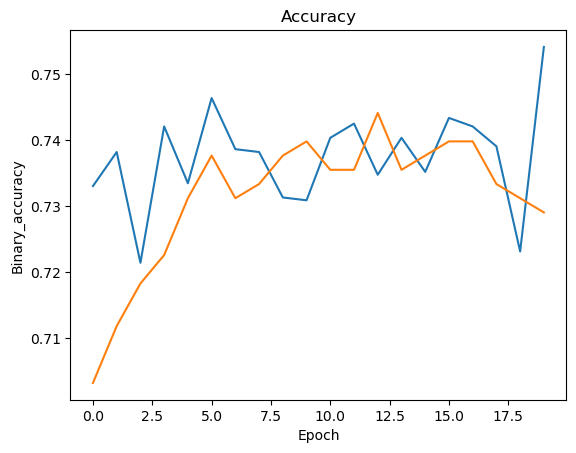

In [19]:
import matplotlib.pyplot as plt
epochs= range(1, 20+1) 
plt.plot(history.history['binary_accuracy']) 
plt.plot(history.history['val_binary_accuracy']) 
plt.title('Accuracy') 
plt.ylabel('Binary_accuracy') 
plt.xlabel('Epoch') 
plt.show()

In [20]:
history = model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    #loss='binary_crossentropy', 
    #metrics=['accuracy']
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [21]:
history = model.fit(
    ds_train,  
    epochs=30,
    validation_data=ds_test,
) 
print('Number of total epochs ran:')
len(history.history['loss']) 

Epoch 1/30
19/19 [==============================] - 226s 12s/step - loss: 0.5197 - binary_accuracy: 0.7395 - val_loss: 0.5079 - val_binary_accuracy: 0.7462
Epoch 2/30
19/19 [==============================] - 222s 12s/step - loss: 0.5153 - binary_accuracy: 0.7451 - val_loss: 0.5077 - val_binary_accuracy: 0.7398
Epoch 3/30
19/19 [==============================] - 222s 12s/step - loss: 0.5151 - binary_accuracy: 0.7425 - val_loss: 0.5064 - val_binary_accuracy: 0.7290
Epoch 4/30
19/19 [==============================] - 225s 12s/step - loss: 0.4958 - binary_accuracy: 0.7635 - val_loss: 0.5020 - val_binary_accuracy: 0.7398
Epoch 5/30
19/19 [==============================] - 218s 11s/step - loss: 0.5014 - binary_accuracy: 0.7541 - val_loss: 0.5047 - val_binary_accuracy: 0.7398
Epoch 6/30
19/19 [==============================] - 224s 12s/step - loss: 0.4994 - binary_accuracy: 0.7519 - val_loss: 0.5038 - val_binary_accuracy: 0.7226
Epoch 7/30
19/19 [==============================] - 237s 12s/ste

30

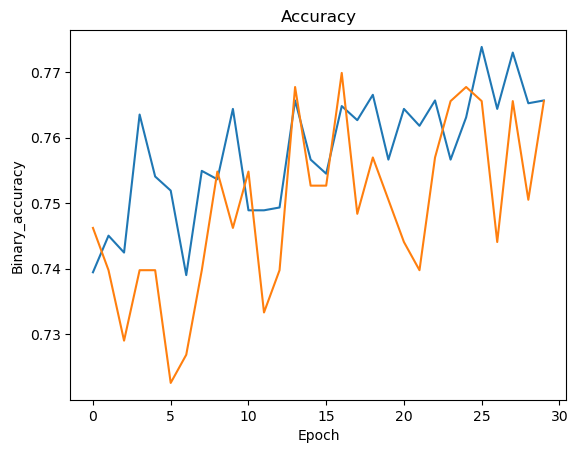

In [22]:
import matplotlib.pyplot as plt
epochs= range(1, 30+1) 
plt.plot(history.history['binary_accuracy']) 
plt.plot(history.history['val_binary_accuracy']) 
plt.title('Accuracy') 
plt.ylabel('Binary_accuracy') 
plt.xlabel('Epoch') 
plt.show()